# Hierarchical clustering of mice based on syllables

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')

# filename = str(data_path + 'all_sequences_5k_09-24-2025')
filename = str(data_path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)

In [4]:
## Get sequences per trial epoch

design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
## Get timing data


# Get timing info
vars = ['trial_id', 'session', 'mouse_name']

elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

# Merge

merged_df = df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
merged_df = merged_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

merged_df['contrast'] = merged_df['contrast'].astype(float)
merged_df['block'] = merged_df['block'].astype(float)

# Timing quantiles and choice
merged_df['response_qt'] = pd.qcut(merged_df['response'], 4, labels=False)/4
merged_df['elongation_qt'] = pd.qcut(merged_df['elongation'], 4, labels=False)/4

merged_df['choice'] = merged_df['trial_type'].str.split().str[3:4].str.join('')
merged_df.loc[merged_df['choice']=='left', 'choice'] = 0
merged_df.loc[merged_df['choice']=='right', 'choice'] = 1

merged_df.loc[merged_df['feedback']=='correct', 'feedback'] = 1
merged_df.loc[merged_df['feedback']=='incorrect', 'feedback'] = 0
del states_file

## Get sequences per trial

In [5]:
all_sequences['session'] = all_sequences['sample'].str[:36]

In [6]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [7]:
session_count = design_df[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>1, 'mouse_name']

In [21]:
all_sequences = all_sequences.loc[all_sequences['mouse_name'].isin(multi_sess_mice)]

## Separate states per variable (one-hot encoding)

In [22]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]
binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

In [23]:
final_matrix = binarized.copy()

## Average per mouse

In [24]:
session_syllables = pd.DataFrame(final_matrix)
session_syllables['mouse_name'] = design_df['mouse_name'].copy()
session_syllables = session_syllables.groupby(['mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean()

([<matplotlib.axis.XTick at 0x76d0069bd4b0>,
 [Text(0, 0, '0'),
  Text(160, 0, '160'),
  Text(320, 0, '320'),
  Text(480, 0, '480'),
  Text(640, 0, '640'),
  Text(800, 0, '800'),
  Text(960, 0, '960'),
  Text(1120, 0, '1120')])

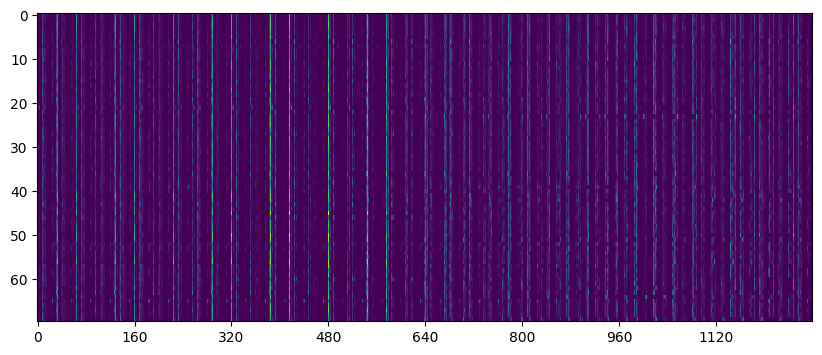

In [11]:
plt.figure(figsize=(10, 4))
plt.imshow(np.array(session_syllables), aspect='auto', cmap='viridis', interpolation='none')
plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))

In [25]:
final_matrix = np.array(session_syllables)

In [13]:
# def split_sessions(all_sequences, n_parts):

#     rng = np.random.default_rng() 
#     all_sequences['session_part'] = np.zeros(len(all_sequences))
#     for s, session in enumerate(all_sequences.session.unique()):
#         session_df = all_sequences.loc[all_sequences['session']==session]
#         n_trials = len(session_df)
#         # Create shuffled labels for parts
#         parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
#         rng.shuffle(parts)  # Shuffle to randomize assignment
#         # els.extend(parts)
#         all_sequences.loc[all_sequences['session']==session, 'session_part'] = parts
#     # Assign to new column
#     all_sequences['session_part'] = all_sequences['session_part'].astype(str)
#     # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
#     all_sequences['session_part_sample'] = all_sequences[['session', 'session_part']].agg(' '.join, axis=1)
#     split_session_df = all_sequences.copy()
#     return split_session_df


def split_mice(all_sequences, n_parts):

    rng = np.random.default_rng() 
    all_sequences['mouse_part'] = np.zeros(len(all_sequences))
    for m, mouse in enumerate(all_sequences.mouse_name.unique()):
        mouse_df = all_sequences.loc[all_sequences['mouse_name']==mouse]
        n_trials = len(mouse_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        all_sequences.loc[all_sequences['mouse_name']==mouse, 'mouse_part'] = parts
    # Assign to new column
    all_sequences['mouse_part'] = all_sequences['mouse_part'].astype(str)
    # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
    all_sequences['mouse_part_sample'] = all_sequences[['mouse_name', 'mouse_part']].agg(' '.join, axis=1)
    split_mouse_df = all_sequences.copy()
    return split_mouse_df


def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['sample', 'mouse_name', 'session', 'trial_type', 'cluster', 'bin'])
    for s, sample in enumerate(trial_clusters['sample'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['sample']==sample]
        session_data = session_data[['sample', 'mouse_name', 'session', 'trial_id', 'trial_type', 'cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['sample', 'mouse_name', 'session', 
                                                                'trial_type', 'cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['sample', 'mouse_name', 'session',
                                    'bin'])['cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'sample', 'session'], columns=['bin', 'cluster'], values='fraction').reset_index().fillna(0)

    return design_df


def binarize(design_df, remap):

    epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
    sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    if remap:
        use_sequences = replace_func(use_sequences)

    use_states = int(max(np.unique(use_sequences)))+1
    timesteps = np.shape(use_sequences)[1]
    binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

    for t in range(timesteps):
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(use_states))
        encoded_arr = label_binarizer.transform(use_sequences[:, t])
        binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

    return binarized


# def prepare_design_mat(design_df):
#     decoded_var = 'mouse_name'
#     var = 'fact_var'

#     mat = pd.DataFrame(design_df)
#     mat['fact_var'] = pd.factorize(design_df[decoded_var])[0]
#     mat[decoded_var] = design_df[decoded_var]

#     use_labels = mat['fact_var'].unique()

#     session_mouse_names = mat.loc[mat['fact_var'].isin(use_labels), decoded_var]
#     session_names = pd.factorize(design_df['session'])[0]
#     named_labels = mat.loc[mat['fact_var'].isin(use_labels), decoded_var].drop_duplicates()
#     use_mat_pre = mat.loc[mat['fact_var'].isin(use_labels)]
#     # array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'sample', 'session']))
#     array_mat = np.array(use_mat_pre.drop(columns=[decoded_var, 'session']))

#     use_mat = pd.DataFrame(array_mat[:, :-1])
#     use_mat[var] = use_mat_pre[var]
    
#     return use_mat, named_labels, session_mouse_names, session_names 

## Repeated samplings

In [26]:
n_parts = 2
repeats = 100

In [15]:
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import pdist, squareform
def jsd(u, v):
    return jensenshannon(u, v)

In [27]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_mouse_df = split_mice(design_df, 2)
    split_mouse_df = split_mouse_df.sort_values(by=['mouse_name', 'session'])
    split_mouse_df = split_mouse_df.loc[split_mouse_df['mouse_part']=='0.0']  # Use only one sample per session each time
    use_samples = split_mouse_df['sample']
    use_sequences = all_sequences.loc[all_sequences['sample'].isin(np.array(use_samples))]
    use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], 
                                 columns=['broader_label'], values='binned_sequence').reset_index().dropna()
    var_names = use_df.keys()[-4:]
        
    use_binarized = binarize(use_df, remap=False)   
    mouse_syllables = pd.DataFrame(use_binarized)
    # mouse_syllables['session'] = use_df['session'].copy()
    mouse_syllables['mouse_name'] = use_df['mouse_name'].copy()
    # session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    mouse_syllables = mouse_syllables.groupby(['mouse_name'])[np.arange(0, 70, 1)].mean().reset_index()
    mouse_syllables = mouse_syllables.sort_values(by=['mouse_name'])

    # use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(mouse_syllables)
    use_mat = mouse_syllables.drop(columns='mouse_name')
    # use_mat = np.sqrt(use_mat)
    # pairwise_matrix = pairwise_distances(use_mat, metric='cosine')
    # pairwise_matrix = pairwise_distances(use_mat, metric='jsd')
    pairwise_matrix = squareform(pdist(use_mat, metric=jensenshannon))

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat)
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix

Repeat 1 of 100
Repeat 2 of 100
Repeat 3 of 100
Repeat 4 of 100
Repeat 5 of 100
Repeat 6 of 100
Repeat 7 of 100
Repeat 8 of 100
Repeat 9 of 100
Repeat 10 of 100
Repeat 11 of 100
Repeat 12 of 100
Repeat 13 of 100
Repeat 14 of 100
Repeat 15 of 100
Repeat 16 of 100
Repeat 17 of 100
Repeat 18 of 100
Repeat 19 of 100
Repeat 20 of 100
Repeat 21 of 100
Repeat 22 of 100
Repeat 23 of 100
Repeat 24 of 100
Repeat 25 of 100
Repeat 26 of 100
Repeat 27 of 100
Repeat 28 of 100
Repeat 29 of 100
Repeat 30 of 100
Repeat 31 of 100
Repeat 32 of 100
Repeat 33 of 100
Repeat 34 of 100
Repeat 35 of 100
Repeat 36 of 100
Repeat 37 of 100
Repeat 38 of 100
Repeat 39 of 100
Repeat 40 of 100
Repeat 41 of 100
Repeat 42 of 100
Repeat 43 of 100
Repeat 44 of 100
Repeat 45 of 100
Repeat 46 of 100
Repeat 47 of 100
Repeat 48 of 100
Repeat 49 of 100
Repeat 50 of 100
Repeat 51 of 100
Repeat 52 of 100
Repeat 53 of 100
Repeat 54 of 100
Repeat 55 of 100
Repeat 56 of 100
Repeat 57 of 100
Repeat 58 of 100
Repeat 59 of 100
Repeat

In [28]:
np.shape(samplings_df['distance_matrix'][0])[0]

46

/tmp/ipykernel_26806/2212015401.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_map=plt.cm.get_cmap('Greys')


(0.0, 46.0)

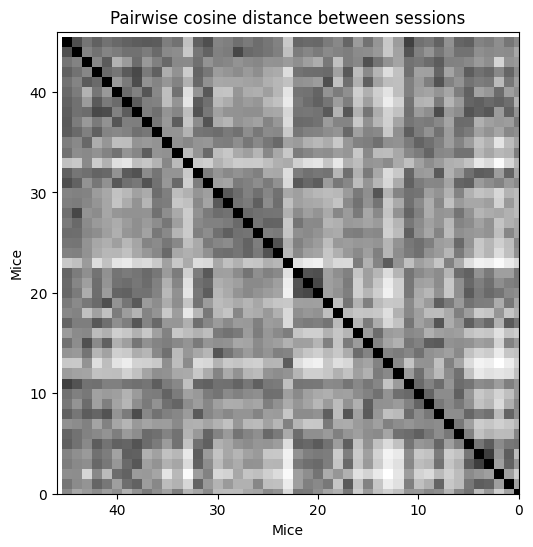

In [29]:
palette=sns.color_palette('Greys', as_cmap=True)
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0), cmap=reversed_map)
plt.xlabel('Mice')
plt.ylabel('Mice')
plt.title('Pairwise cosine distance between sessions')

plt.xlim([np.shape(samplings_df['distance_matrix'][0])[0], 0])
plt.ylim([0, np.shape(samplings_df['distance_matrix'][0])[0]])

/tmp/ipykernel_12862/2212015401.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_map=plt.cm.get_cmap('Greys')


(0.0, 70.0)

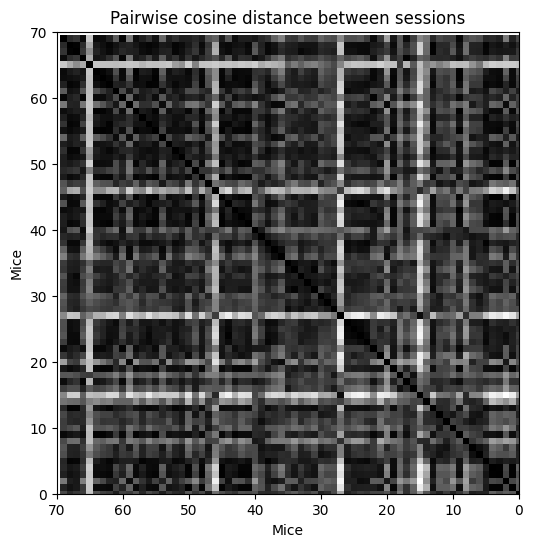

In [15]:
palette=sns.color_palette('Greys', as_cmap=True)
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0), cmap=reversed_map)
plt.xlabel('Mice')
plt.ylabel('Mice')
plt.title('Pairwise cosine distance between sessions')

plt.xlim([np.shape(samplings_df['distance_matrix'][0])[0], 0])
plt.ylim([0, np.shape(samplings_df['distance_matrix'][0])[0]])

## Cluster each repeat and build consensus matrix

In [30]:
palette = sns.color_palette("Greys", 10)

/tmp/ipykernel_26806/3111325539.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/tmp/ipykernel_26806/3111325539.py:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='jensenshannon')
/tmp/ipykernel_26806/3111325539.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column

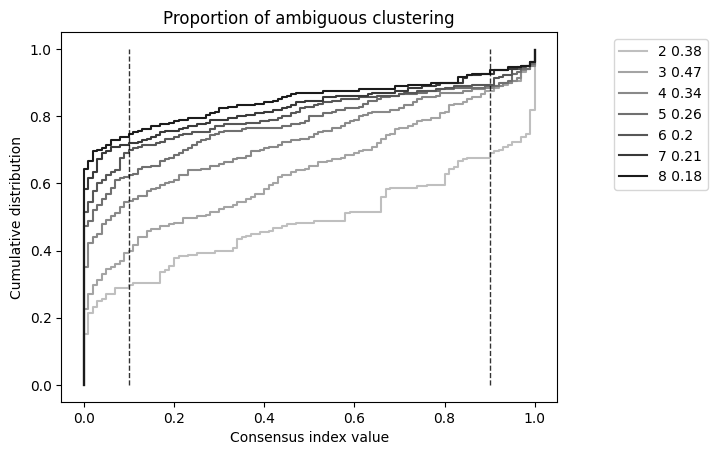

In [34]:
K = [2, 3, 4, 5, 6, 7, 8, ]
# K = [6, 7, 8, 9, 10, 11, 30]
all_ks = pd.DataFrame()

samplings_df['k'] = samplings_df['repeat'] * np.nan
samplings_df['clusters'] = samplings_df['repeat'] * np.nan

for kk, k in enumerate(K):
    
    samplings_df['k'] = k
    samplings_df['clusters'] = samplings_df['repeat'] * np.nan
    n_samples, _ = pairwise_matrix.shape
    consensus_matrix = np.zeros((n_samples, n_samples))

    for r in range(repeats):
        pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
        linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
        linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='jensenshannon')
        # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
        # plt.show()
        
        clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    
        # kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(pairwise_matrix)
        # # kmeans.labels_
        # clusters = kmeans.predict(pairwise_matrix)
        
        samplings_df['clusters'][r] = clusters 

        for i in range(n_samples):
            for j in range(i, n_samples):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats
    # Save
    if i == 0:
        all_ks = samplings_df
    else:
        all_ks = pd.concat([all_ks, samplings_df]) 

    e = ECDF(np.ravel(consensus_matrix))
    low_index = np.where(e.x>.1)[0][0]
    high_index = np.where(e.x<0.9)[0][-1]
    PAC = e.y[high_index] - e.y[low_index]
    plt.step(e.x[1::10], e.y[1::10], label=str(str(k)+' '+str(np.round(PAC, 2))), color=palette[kk+3])
plt.vlines(0.1, 0, 1, linestyle='dashed', color='black', alpha=.8, linewidth=1)
plt.vlines(0.9, 0, 1, linestyle='dashed', color='black', alpha=.8, linewidth=1)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.xlabel('Consensus index value')
plt.ylabel('Cumulative distribution')
plt.title('Proportion of ambiguous clustering')
plt.show()

# Run with final k

In [35]:
k = 6
samplings_df['k'] = k
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    # linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='jensenshannon')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    
    
    # kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(pairwise_matrix)
    # # kmeans.labels_
    # clusters = kmeans.predict(pairwise_matrix)
    
    
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                        
# Normalize to [0, 1]
consensus_matrix /= repeats

/tmp/ipykernel_26806/442377960.py:10: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='jensenshannon')
/tmp/ipykernel_26806/442377960.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://p

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50')])

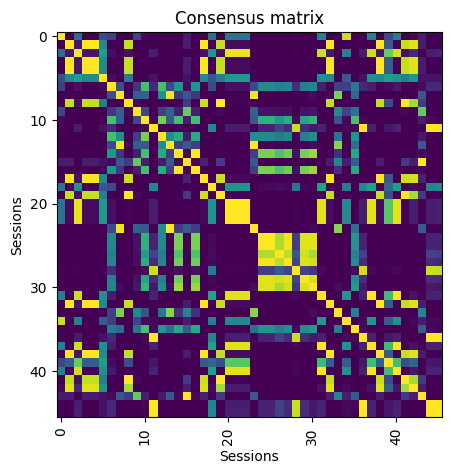

In [36]:
fig, ax = plt.subplots(figsize=[6, 5])
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Consensus matrix')

plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

In [37]:
# Associate clusters with unsplit data; attention to sorting!!
use_sequences = all_sequences.copy()
use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = use_df.keys()[-4:]
    
use_binarized = binarize(use_df, remap=False)
full_mouse_syllables = pd.DataFrame(use_binarized)
# full_session_syllables['session'] = np.array(use_df['session'])
full_mouse_syllables['mouse_name'] = np.array(use_df['mouse_name'])
full_mouse_syllables = full_mouse_syllables.groupby(['mouse_name'])[np.arange(0, np.shape(binarized)[1], 1)].mean().reset_index()
full_mouse_syllables = full_mouse_syllables.sort_values(by=['mouse_name'])

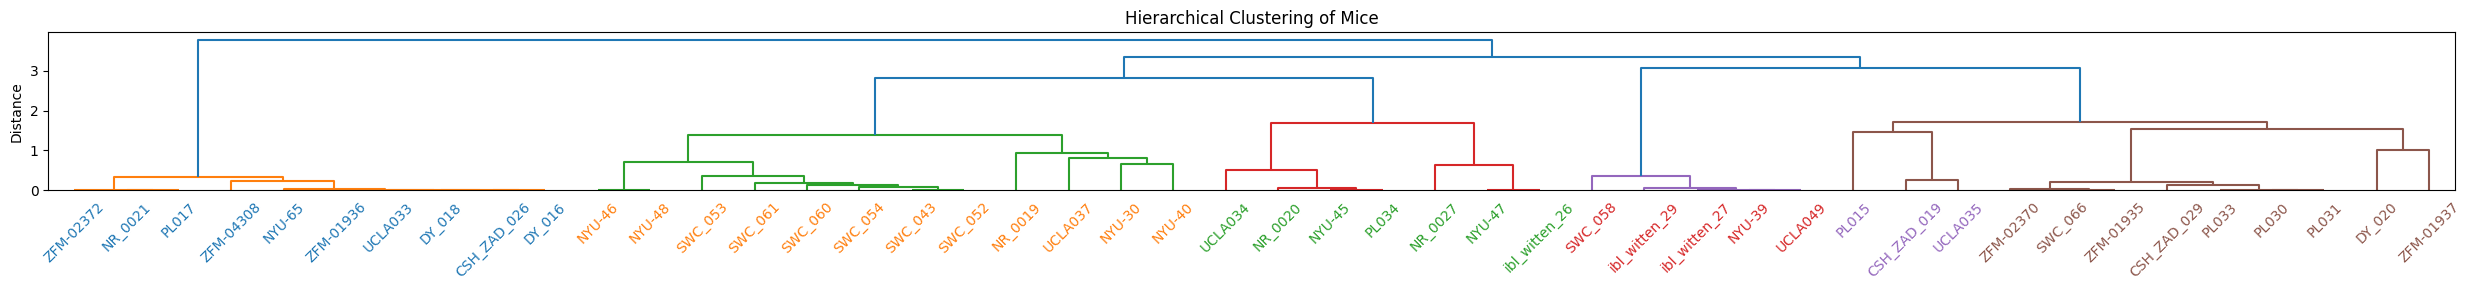

In [38]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
from scipy.spatial.distance import squareform
D = 1 - consensus_matrix  # distance = 1 - similarity
D = consensus_matrix
Z = linkage(consensus_matrix, method='average')  #, metric='cosine')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
# final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1    
    
mouse_labels = np.array(full_mouse_syllables['mouse_name'])#.unique()
# design_df['session_cluster'] = clusters 

# Plot dendrogram
fig, ax = plt.subplots(figsize=(25, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("tab10", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Mice")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()

In [39]:
full_mouse_syllables['mouse_cluster'] = final_clusters.copy()

## Save

In [40]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
filename = "6_cluster_per_mice_repeated_measures"
full_mouse_syllables.to_parquet(data_path+filename)  

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/io/parquet.py:191: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


# PCA

In [41]:
n_components = 40
use_data = np.mean(list(samplings_df['distance_matrix']), axis=0).copy()
# use_data = consensus_matrix.copy()
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(use_data)
X_pca = pca.fit_transform(standardized_X)
# X_pca = pca.fit_transform(use_data)


Text(0.5, 1.0, 'Explained Variance by PCA')

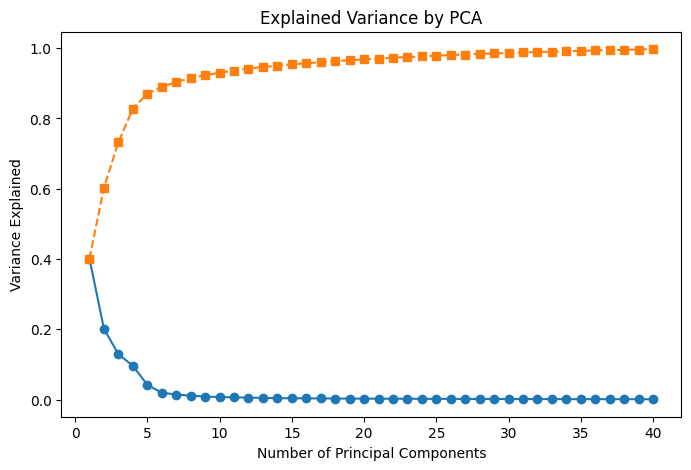

In [42]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

Text(0, 0.5, 'PC 2')

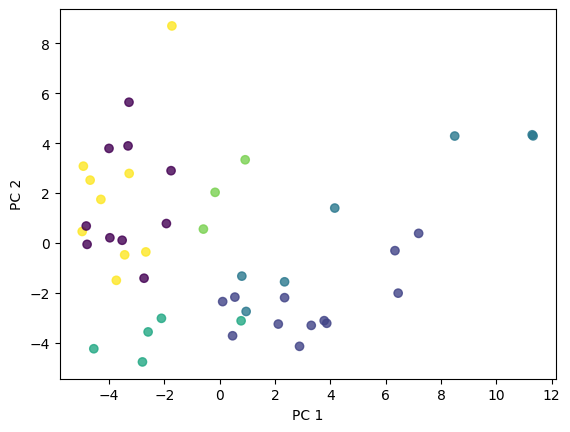

In [43]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.8, c=final_clusters)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [44]:
import plotly.graph_objects as go
from matplotlib import cm
import numpy as np

# get tab10 RGBA colors from matplotlib
tab10 = cm.get_cmap('tab10')
colors = [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})' 
          for r, g, b, a in tab10(np.linspace(0, 1, 10))]

fig = go.Figure(
    data=go.Scatter3d(
        x=X_pca[:,0],
        y=X_pca[:,1],
        z=X_pca[:,2],
        mode='markers',
        marker=dict(
            size=5,
            color=[colors[c] for c in final_clusters]  # assign tab10 color per cluster
        )))

fig.show()


/tmp/ipykernel_26806/4243559012.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = cm.get_cmap('tab10')


## UMAP

In [45]:
reducer = umap.UMAP(random_state= 42, n_components=3)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(use_data)

# mouse_embedding = reducer.fit_transform(use_data)
mouse_embedding = reducer.fit_transform(standardized_X)
mouse_embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(46, 3)

In [41]:
import plotly.graph_objects as go

# Create trace, sizing bubbles by planet diameter
fig = go.Figure(data=go.Scatter3d(
    x = mouse_embedding[:, 0],
    y = mouse_embedding[:, 1],
    z = mouse_embedding[:, 2],
    mode = 'markers',
    marker = dict(
        color = final_clusters
        
        )
))
fig.show()

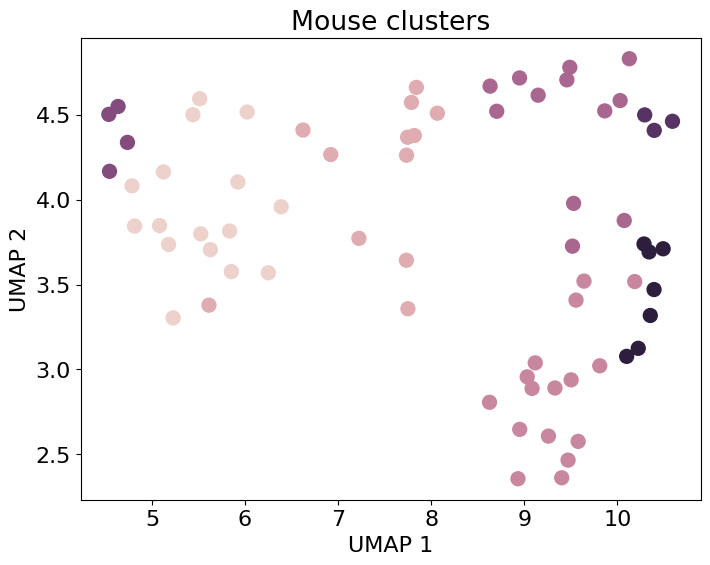

In [45]:
# Step 2: Perform KMeans Clustering
data_2d = mouse_embedding
# kmeans = KMeans(n_clusters=5, random_state=2024)
# kmeans.fit(data_2d)
# mouse_y_kmeans = kmeans.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=final_clusters, s=100, alpha=1, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))


# centroids = kmeans.cluster_centers_
# for c, cent in enumerate(centroids):
#     dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')

plt.title("Mouse clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

## Crossing with other behavioral variables

In [42]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()
reaction
full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_4363/2073039802.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



In [58]:
# mouse_names = df['mouse_name'].copy().drop_duplicates().reset_index()
# mouse_names['cluster'] = final_clusters.copy()
pca_df = pd.DataFrame(X_pca)
pca_df['mouse_name'] = full_mouse_syllables['mouse_name']
pca_df['mouse_cluster'] = full_mouse_syllables['mouse_cluster']

var = 'choice'
grouped = merged_df.groupby(['mouse_name'])[var].mean().reset_index()
merged = pca_df.merge(grouped, on=['mouse_name'])
merged = merged.merge(full_learning[['mouse_name', 'training_time']], on=['mouse_name'])

In [59]:
merged = merged.groupby(['mouse_name', 'training_time'])[pc].mean().reset_index().dropna()
var = 'training_time'

In [57]:
pc = 3

PearsonRResult(statistic=np.float64(0.037040294531419445), pvalue=np.float64(0.7677887004252945))


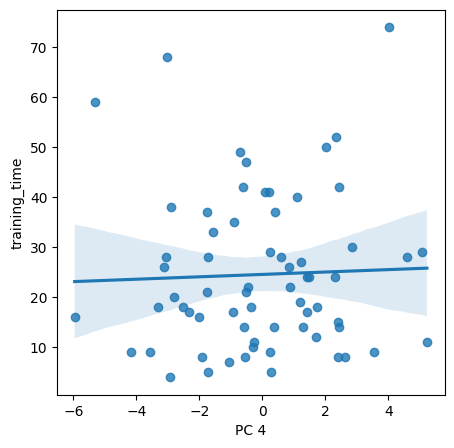

In [60]:
plt.figure(figsize=(5, 5))
sns.regplot(x=np.array(merged[pc]).astype(float), y=merged[var].astype(float), ci=95) 
plt.xlabel('PC '+str(pc+1))
# plt.ylabel('Training time (sessions)')
plt.ylabel(str(var))

from scipy.stats import spearmanr, pearsonr

res = pearsonr(np.array(merged[pc]).astype(float), np.array(merged[var]).astype(float))
print(res)

## Visualize

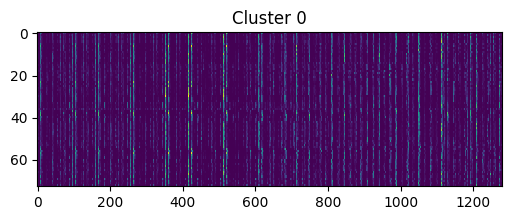

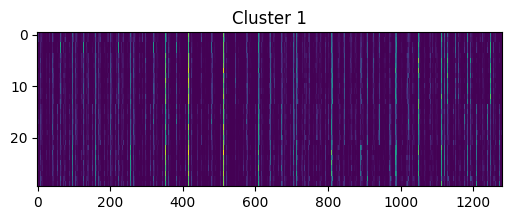

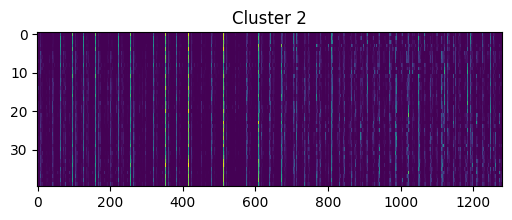

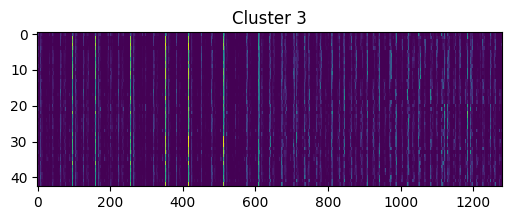

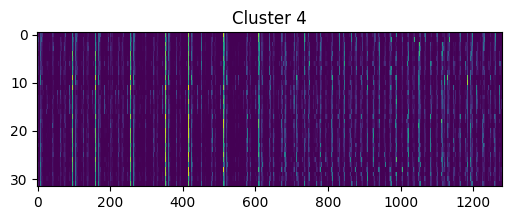

In [88]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(full_session_syllables[np.arange(0,np.shape(final_matrix)[1], 1)])[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    # plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()